In [11]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [12]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (warning)
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
# 학습 or 실행 도중 오류가 나서 session이 안닫혔을 경우
tf.reset_default_graph ()

# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module8

    -Part 04. 단어 임베딩
    
        04. 사전 학습된 모델의 사용

##### 영어 Word2Vec 만들기
- 사전 학습된 모델에서 임베딩 미세조정
- 구글 뉴스 모델 3백만 단어, 임베딩 차원 300

In [ ]:
from gensim.models import KeyedVectors

# 구글의 이미 훈련된 Word2Vec 모델을 로드합니다.
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
model.vectors.shape

In [ ]:
print(model.similarity('this', 'is')) # 유사도 계산하기
print(model.similarity('post', 'book'))
print(model.similarity('mail', 'document'))

##### 한국어 Word2Vec 만들기

In [ ]:
import gensim
model = gensim.models.Word2Vec.load('ko.bin')

In [ ]:
a = model.wv.most_similar('강아지')
print(a)

##### 정제된 데이터로는 이렇게 쉽게 나올 수 있지만, 가공되지 않은 데이터는 수많은 전처리를 해줘야 함
- Web 크롤러 -> 태그 모두 처리
- A나 the 같은 관사는 빼주는 것도 성능이 좋아짐
- 형태소 분석을 통해서 의미가 같은 것들을 통일
    - fly와 flies를 다른 뜻으로 생각하면 안됨
    - Apple과 apple은 같은 것
    - 형용사 부사 등 의미가 비슷한 것은 비슷하게 처리해도 좋을 때가 있음
    
##### 참고
- Word2Vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만
- 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델
- 우선 적당하게 데이터를 나열해주면 Word2Vec은 위치가 근접한 데이터를 유사도가 높은 벡터를 만들어준다는 점에서 착안된 아이디어

##### 영화평가 데이터

In [ ]:
import csv

f = open("ratings.txt",'r',encoding = 'utf-8')
rdr = csv.reader(f, delimiter = '\t')
rdw = list(rdr)

print(rdw[:3])

f.close()

In [ ]:
from konlpy.tag import Okt
okt = Okt()

result = []
for line in rdw:
    malist = okt.pos(line[1], norm = True, stem = True)
    r = []
    for word in malist:
        if not word[1] in ["Josa","Eomi","Punctuation"]:
            r.append(word[0])
    rl = (" ".join(r)).strip()
    result.append(rl)

In [ ]:
with open("NaverMovie.nlp",'w',encoding = 'utf-8') as fp:
    fp.write("\n".join(result))

In [ ]:
from gensim.models import word2vec

wData = word2vec.LineSentence("NaverMovie.nlp")
wModel = word2vec.Word2Vec(wData, size = 200, window = 10, min_count = 2, sg = 1)
wModel.save("NaverMovie.model")
print('Word2Vec Modeling finished')

In [ ]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("NaverMovie.model")

In [ ]:
a = model.wv.most_similar("액션")
print(a)

##### 토지 모델
https://yeo0.github.io/data/2018/11/16/2.-Word2Vec으로-문장을-벡터로-변환하기/

In [ ]:
import codecs
from bs4 import BeautifulSoup
from konlpy.tag import Twitter
from gensim.models import word2vec

#utf-16 인코딩으로 파일열고 글자 출력
fp=codecs.open("C:/Users/Affinity/Desktop/study/Module04/modeule04/ch02/BEXX0003.txt", "r",encoding="utf-16")
soup=BeautifulSoup(fp, 'html.parser')
body=soup.select_one("body > text")
text=body.getText()

#텍스트 한줄씩 처리하기
twitter=Twitter()
results=[]
lines=text.split("\n")

for line in lines:
    #단어기본형 활용. 형태소 분석
    malist=twitter.pos(line, norm=True, stem=True)
    r=[]
    for (word, pumsa) in malist:
        #어미/조사/구두점 등은 대상에서 제외
        if not pumsa in ["Josa","Eomi","Punctuation"]:
            r.append(word)

    rl=(" ".join(r)).strip() #양쪽 공백 추가하여 조인
    results.append(rl)
    print(rl)

#파일로 출력
with open('toji.wakati','w',encoding='utf-8') as fp:
    fp.write("\n".join(results))
    
#Word2Vec 
data=word2vec.LineSentence('toji.wakati')
model=word2vec.Word2Vec(data,size=200,window=10,hs=1,min_count=2,sg=1) #size=listsize
model.save("toji.model")
print("ok")


In [ ]:
model.most_similar(model.most_similar(positive=["집"]))

# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module8

    -Part 05. Session-based 딥러닝
    
        01. RNN

##### RNN의특징
- RNN은은닉층에서 활성화 함수를통해나온 결과값을 출력층 방향으로도 보내 면서, 다시은닉층의 다음 계산의입력으로 보내는특징을 갖고있음
    - 실제로는편향b도은닉층과출력층의입력으로존재하지만앞으로의신경망의그림 에서편향b는생략
- RNN에서는 은닉층에서 활성화 함수를통해 결과를내보내는 역할을 하는노드 (node)를 셀(cell)이라고 함
    - 셀은이전의값을기억하려고하는일종의메모리역할을수행할수있으므로이를보 통메모리셀또는RNN 셀이라고표현

##### RNN의 형태
- 일대다: 하나의 입력에대해서 여러개의출력(one-to-many)
    - 하나의사진이미지입력에대해서사진의제목을출력을내놓는이미지캡셔닝(Image Captioning) 작업에사용
    - 사진의제목은단어들의나열이므로시퀀스의형태를가짐
- 다대일: 다수의 입력에대해서 하나의출력(many-to-one)
    - 입력데이터으로부터긍정적감성인지부정적감성인지를판별하는감성분류 (Sentiment Classification),
    - 입력데이터가어떤종류의문서인지를판별하는문서분류(Document Classification)에 사용
- 다대다(many-to-many)
    - 입력문장으로부터대답을출력하는챗봇,입력문장으로부터번역된문장을출력하 는번역기, 개체명인식, 품사태깅등에이용
    
##### RNN의 활용 분야
- 영상내물체인식및생성
    - 영상을좌->우, 위->아래로이동하면서영상내물체인식하거나생성
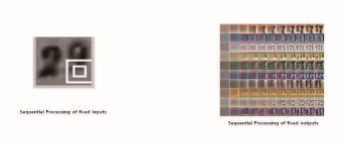

- 시계열예측(Time Series Prediction)
    - 주가예측, 탑승객인원예측, 날씨예측등


- 이미지 캡셔닝
    - CNN과 RNN을 조합하여 이미지의 캡션을 자동으로 생성
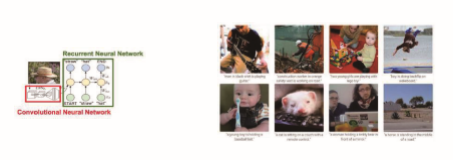

- 언어번역
    - 입력에 대한 RNN과 출력에 대한 RNN을 연결하여 구성
- 음성인식
    - RNN을 여러 층 쌓아 구성하여 음성 인식을 수행함
    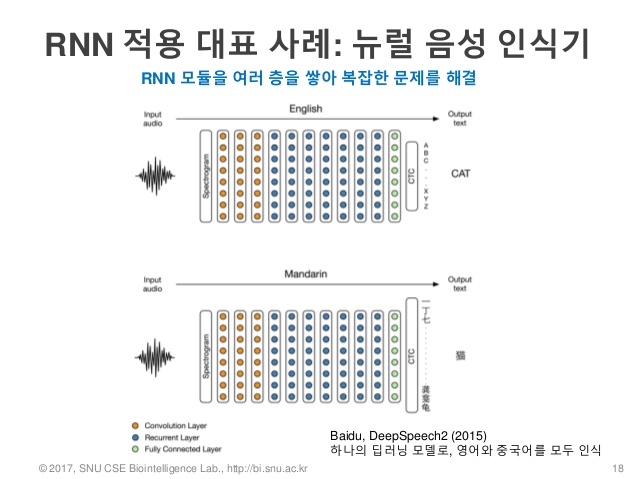

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN

model = Sequential()
model.add(SimpleRNN(3, batch_input_shape = (8, 2, 10)))
# batch size = 8
# 보통은 input_shape이나 batch를 이용할 시 batcy_input_shape으로 지정
model.summary()

- return_sequences
    - return_sequences = True로 설정하면 메모리 셀이 모든 시점에서 output
    - return_sequences = False(default)로 설정하면 마지막 셀에서만 출력

In [ ]:
model = Sequential()
model.add(SimpleRNN(3, batch_input_shape = (8,2,10), return_sequences = True))
model.summary()

### BRNN(Bidirectional RNN, 양방향 순환신경망)
##### 양방향 순환 신경망 개요
- RNN이과거시점(time-step)의 데이터들을 참고해찾고자하는 정답을예측하 지만실제 문제에서는 과거 시점의 데이터만 고려하는것이아니라 향후시점 의데이터에 힌트가 있는경우도많음
- 그래서이전시점의 데이터뿐만 아니라이후 시점의데이터도 힌트로활용하기 위해서고안된 것이양방향RNN
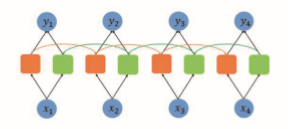
- 양방향RNN은 하나의출력값을 예측하기 위해기본적으로 두개의메모리셀 을사용
    - 첫번째메모리셀은앞시점의은닉상태(Forward States)를전달받아 현재의은닉상태를계산
    - 두번째메모리셀은뒤시점의은닉상태(Backward States)를전달받아 현재의은닉상태를계산
    - 그리고이두개의값모두가하나의출력값을예측하기위해사용됨

##### RNN을 이용한 언어 모델링

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN
tf.enable_eager_execution()

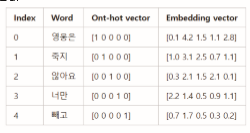

In [2]:
train_X = [[0.1, 4.2, 1.5, 1.1, 2.8], [1.0, 3.1, 2.5, 0.7, 1.1], [0.3, 2.1, 1.5, 2.1, 0.1], [2.2, 1.4, 0.5, 0.9, 1.1]]
print(np.shape(train_X))

(4, 5)


- RNN은 3D 텐서를 입력 받기 때문에 2D -> 3D로 변환
    - batch가 1인 형태

In [3]:
train_X = [[[0.1, 4.2, 1.5, 1.1, 2.8], [1.0, 3.1, 2.5, 0.7, 1.1], [0.3, 2.1, 1.5, 2.1, 0.1], [2.2, 1.4, 0.5, 0.9, 1.1]]]
train_X = np.array(train_X, dtype = np.float32)
print(train_X.shape)

(1, 4, 5)


In [4]:
rnn = SimpleRNN(3, return_sequences = True, return_state = True)

hidden_states, last_states = rnn(train_X)

# 입력으로 사용한 훈련 데이터
print('train_X : {}, shape : {}'.format(train_X, train_X.shape))
# 모든 time_step의 은닉상태
print('hidden states : {}, shape: {}'.format(hidden_states, hidden_states.shape))
# 마지막 은닉 상태
print('last hidden state: {}, shape: {}'.format(last_states, last_states.shape))

train_X : [[[0.1 4.2 1.5 1.1 2.8]
  [1.  3.1 2.5 0.7 1.1]
  [0.3 2.1 1.5 2.1 0.1]
  [2.2 1.4 0.5 0.9 1.1]]], shape : (1, 4, 5)
hidden states : [[[ 0.3811791  -0.91783816  0.9232012 ]
  [ 0.9900057   0.5576731   0.9895901 ]
  [ 0.990818    0.63135695  0.99492   ]
  [ 0.7166087   0.8715705   0.9955017 ]]], shape: (1, 4, 3)
last hidden state: [[0.7166087 0.8715705 0.9955017]], shape: (1, 3)


##### RNN을 이용한 언어 모델링
- 입력으로사용한훈련데이터는(batch_size, timesteps, input_dim)에해당하는(1, 4, 5) 의크기를가지는3D 텐서
- return_sequences=True모든시점(time-step)에대해서출력을리턴
    − 이에따라(batch_size, timesteps, output_dim)에 해당하는(1, 4, 3) 크기의3D 텐서를출력
    − 하지만return_sequences=True를 선택해주지않는다면, RNN은오직마지막은닉상태만출력
    − 따라서이번실습에서는마지막은닉상태도따로리턴을받아서크기를확인 
- return_state=True RNN은마지막은닉상태를리턴
    − 마지막은닉상태의크기를보면(1, 3)
    − 이는(batch_size, output_dim)에 해당
##### 출력층에 대한설계
- 옆의그림은출력층을제대로설계했을때, 시점3일때의동작을보여줌
- 궁극적으로해야할것은실제값y와 출력층이만들어낸예측값y^에 대해서 손실함수(loss function)을통해서학습하는것
    − 여기서실제값y의역할을원-핫벡터가해야함
    − 시점이2일때실제값y는다음단어에해당되는 '너만'의원-핫벡터인[0 0 0 1 0]
    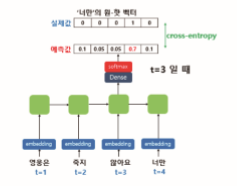

In [3]:
# 한국어 문장을 선언
text = "나랑 점심 먹으러 갈래 메뉴는 햄버거 점심 메뉴 좋지"

In [4]:
# 토큰화와 정수 인코딩
from tensorflow.keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]
# [0]을 햊지 않으면 [[contents]]와 같은 리스트 안의 리스트 형태로 저장됨
# [0]을 해주면 [contents]와 같은 하나의 리스트로 저장됨

In [5]:
# 실제 단어 개수는 8이지만, 뒤에서 필요한 배열의 크기는 9이므로 +1 해줌
vocab_size = len(t.word_index) + 1
# 케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만
# 케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에
# 배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언
print('단어 집합의 크기: %d' % vocab_size)

단어 집합의 크기: 9


In [6]:
# 각 단어의 빈도수에 따라서 부여된 인덱스 확인
print(t.word_index)
# 점심이라는 단어가 2개 사용되었으므로 1번으로 지정됨(나머지는 한번만 나옴)

{'점심': 1, '나랑': 2, '먹으러': 3, '갈래': 4, '메뉴는': 5, '햄버거': 6, '메뉴': 7, '좋지': 8}


In [7]:
# 여기서 문장의 Bigram을 추출한다고 봐도 무방함
sequences = list()
for c in range(1, len(encoded)):
    sequence = encoded[c-1:c+1]
    # 단어를 두개씩 묶어서 저장해준다. 이는 X와 Y의 관계를 구성하기 위함
    sequences.append(sequence)
print('단어 묶음의 개수: %d' % len(sequences))

단어 묶음의 개수: 8


In [8]:
print(sequences)

[[2, 1], [1, 3], [3, 4], [4, 5], [5, 6], [6, 1], [1, 7], [7, 8]]


In [9]:
# 첫 번쨰 열과, 두 번쨰 열을 X와 y에 저장하는 코드
import numpy as np
X, y = zip(*sequences)
# 첫번째 열이 X, 두번째 열이 y, * 이게 뭔가 열지정같은 느낌
X = np.array(X)
y = np.array(y)

In [10]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes = vocab_size) # 원핫인코딩
print(y)

[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.models import Sequential
tf.compat.v1.disable_eager_execution()

model = Sequential()
model.add(Embedding(vocab_size, 9, input_length = 1))
# 단어 집합의 크기는 9, 임베딩 벡터의 크기는 9, 각 sample의 길이느 ㄴ단어 한 개이므로 길이는 1
model.add(SimpleRNN(9))
# RNN의 결과값으로 나오는 벡터의 차원 또한 9로 한다. 더 크게 해주어도 상관은 없음
model.add(Dense(vocab_size, activation = 'softmax'))
# 출력층을 지나서 나오는 벡터의 크기도 9로 한다

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X, y, epochs=500, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 1s - loss: 2.1771 - acc: 0.1250
Epoch 2/500
 - 0s - loss: 2.1733 - acc: 0.1250
Epoch 3/500
 - 0s - loss: 2.1696 - acc: 0.1250
Epoch 4/500
 - 0s - loss: 2.1658 - acc: 0.2500
Epoch 5/500
 - 0s - loss: 2.1620 - acc: 0.2500
Epoch 6/500
 - 0s - loss: 2.1582 - acc: 0.2500
Epoch 7/500
 - 0s - loss: 2.1544 - acc: 0.3750
Epoch 8/500
 - 0s - loss: 2.1505 - acc: 0.3750
Epoch 9/500
 - 0s - loss: 2.1467 - acc: 0.3750
Epoch 10/500
 - 0s - loss: 2.1428 - acc: 0.5000
Epoch 11/500
 - 0s - loss: 2.1389 - acc: 0.5000
Epoch 12/500
 - 0s - loss: 2.1349 - acc: 0.5000
Epoch 13/500
 - 0s - loss: 2.1310 - acc: 0.6250
Epoch 14/500
 - 0s - loss: 2.1270 - acc: 0.7500
Epoch 15/500
 - 0s - loss: 2.1230 - acc: 0.7500
Epoch 16/500
 - 0s - loss: 2.1189 - acc: 0.7500
Epoch 17/500
 - 0s - loss: 2.1148 - acc: 0.7500
Epoch 18/500
 - 0s - loss: 2.1107 - acc: 0.7500
Epoch 19/500
 - 0s - loss: 2.1066 - acc: 0.7500
Epoch 20/500
 - 0s - loss: 2.1024 - acc: 0.7500
E

Epoch 165/500
 - 0s - loss: 1.0063 - acc: 0.8750
Epoch 166/500
 - 0s - loss: 0.9989 - acc: 0.8750
Epoch 167/500
 - 0s - loss: 0.9915 - acc: 0.8750
Epoch 168/500
 - 0s - loss: 0.9841 - acc: 0.8750
Epoch 169/500
 - 0s - loss: 0.9768 - acc: 0.8750
Epoch 170/500
 - 0s - loss: 0.9696 - acc: 0.8750
Epoch 171/500
 - 0s - loss: 0.9624 - acc: 0.8750
Epoch 172/500
 - 0s - loss: 0.9552 - acc: 0.8750
Epoch 173/500
 - 0s - loss: 0.9482 - acc: 0.8750
Epoch 174/500
 - 0s - loss: 0.9411 - acc: 0.8750
Epoch 175/500
 - 0s - loss: 0.9342 - acc: 0.8750
Epoch 176/500
 - 0s - loss: 0.9273 - acc: 0.8750
Epoch 177/500
 - 0s - loss: 0.9204 - acc: 0.8750
Epoch 178/500
 - 0s - loss: 0.9136 - acc: 0.8750
Epoch 179/500
 - 0s - loss: 0.9069 - acc: 0.8750
Epoch 180/500
 - 0s - loss: 0.9002 - acc: 0.8750
Epoch 181/500
 - 0s - loss: 0.8935 - acc: 0.8750
Epoch 182/500
 - 0s - loss: 0.8869 - acc: 0.8750
Epoch 183/500
 - 0s - loss: 0.8804 - acc: 0.8750
Epoch 184/500
 - 0s - loss: 0.8740 - acc: 0.8750
Epoch 185/500
 - 0s 

Epoch 333/500
 - 0s - loss: 0.3733 - acc: 0.8750
Epoch 334/500
 - 0s - loss: 0.3719 - acc: 0.8750
Epoch 335/500
 - 0s - loss: 0.3705 - acc: 0.8750
Epoch 336/500
 - 0s - loss: 0.3691 - acc: 0.8750
Epoch 337/500
 - 0s - loss: 0.3677 - acc: 0.8750
Epoch 338/500
 - 0s - loss: 0.3664 - acc: 0.8750
Epoch 339/500
 - 0s - loss: 0.3651 - acc: 0.8750
Epoch 340/500
 - 0s - loss: 0.3637 - acc: 0.8750
Epoch 341/500
 - 0s - loss: 0.3624 - acc: 0.8750
Epoch 342/500
 - 0s - loss: 0.3611 - acc: 0.8750
Epoch 343/500
 - 0s - loss: 0.3599 - acc: 0.8750
Epoch 344/500
 - 0s - loss: 0.3586 - acc: 0.8750
Epoch 345/500
 - 0s - loss: 0.3573 - acc: 0.8750
Epoch 346/500
 - 0s - loss: 0.3561 - acc: 0.8750
Epoch 347/500
 - 0s - loss: 0.3548 - acc: 0.8750
Epoch 348/500
 - 0s - loss: 0.3536 - acc: 0.8750
Epoch 349/500
 - 0s - loss: 0.3524 - acc: 0.8750
Epoch 350/500
 - 0s - loss: 0.3512 - acc: 0.8750
Epoch 351/500
 - 0s - loss: 0.3500 - acc: 0.8750
Epoch 352/500
 - 0s - loss: 0.3488 - acc: 0.8750
Epoch 353/500
 - 0s 

In [13]:
# word_index.items()는 key와 value의 쌍을 튜플로 묶은 값을 dict_items 객체로 리턴
print(t.word_index.items())

dict_items([('점심', 1), ('나랑', 2), ('먹으러', 3), ('갈래', 4), ('메뉴는', 5), ('햄버거', 6), ('메뉴', 7), ('좋지', 8)])


In [16]:
# 모델, 토크나이저, 현재 단어를 받아온다.
def predict_next_word(model, t, current_word):
   # 현재 단어에 대한 정수 인코딩
    encoded = t.texts_to_sequences([current_word])[0]
    encoded = np.array(encoded)
    # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(에측한 단어)를 result에 저장
    result = model.predict_classes(encoded, verbose=0)
    # 위에서 실습한 것처럼 단어와 인덱스를 리턴
    for word, index in t.word_index.items():
        # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
        if index == result:
            return word # 그 단어를 출력

In [17]:
print(predict_next_word(model, t, '먹으러'))

갈래


In [18]:
def sentence_generation(model, t, current_word, n):
    # 처음 들어온 단어도 마지막에 같이 출력하기 위해 저장
    init_word = current_word
    sentence = ''
    for _ in range(n): # n번 반복
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = np.array(encoded)
        result = model.predict_classes(encoded, verbose=0)
        for word, index in t.word_index.items():
            if index == result:
                break # 해당 단어가 예측 단어이므로 break
        current_word = word # 예측 단어를 현재 단어로 변경
        sentence = sentence + '' + word # 예측 단어를 문장에 저장
    # for 문이므로 이 행동을 다시 반복
    sentence = init_word + sentence
    return sentence

In [19]:
print(sentence_generation(model, t, '먹으러', 6))

먹으러갈래메뉴는햄버거점심메뉴좋지


In [1]:
text="""경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [2]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts([text])
encoded = t.texts_to_sequences([text])[0]

In [3]:
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기 : %d'%vocab_size)

단어 집합의 크기 : 12


In [4]:
print(t.word_index)

{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [5]:
sequences = list()
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)
        
print('훈련 데이터의 개수: %d' % len(sequences))

훈련 데이터의 개수: 11


In [6]:
print(sequences)

[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


In [7]:
print(max(len(i) for i in sequences)) # 모든 데이터의 길이가 가장 긴 데이터의 길이 출력

6


- 모든 데이터에 대해 6으로 맞춰주는 코드
    - pad_sequences()는모든데이터에대해서0을추가하여길이를맞춰줌
    - maxlen의값으로6을주면모든데이터의길이를6으로맞춰주며, padding의인자로'pre'를주면길이가6보다짧은데이터의앞을0으로채움
    - 길이가6보다짧은모든데이터에대해서앞에0을채움에따라, 모든데이터의길이가6이된것을확인


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences, maxlen=6, padding='pre')

In [9]:
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [11]:
# X와 y값 분리
import numpy as np
sequences = np.array(sequences)
X = sequences[:, :-1]
y = sequences[:, -1]

In [12]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes = vocab_size)
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [27]:
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = 5))
# y를 제거햇으므로 x의 길이는 6-1=5
model.add(SimpleRNN(32))
model.add(Dense(vocab_size, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(X, y, epochs = 200, verbose=2)

Epoch 1/200
 - 0s - loss: 2.4805 - acc: 0.0909
Epoch 2/200
 - 0s - loss: 2.4639 - acc: 0.1818
Epoch 3/200
 - 0s - loss: 2.4475 - acc: 0.1818
Epoch 4/200
 - 0s - loss: 2.4311 - acc: 0.1818
Epoch 5/200
 - 0s - loss: 2.4146 - acc: 0.0909
Epoch 6/200
 - 0s - loss: 2.3977 - acc: 0.3636
Epoch 7/200
 - 0s - loss: 2.3803 - acc: 0.3636
Epoch 8/200
 - 0s - loss: 2.3625 - acc: 0.4545
Epoch 9/200
 - 0s - loss: 2.3440 - acc: 0.4545
Epoch 10/200
 - 0s - loss: 2.3248 - acc: 0.3636
Epoch 11/200
 - 0s - loss: 2.3049 - acc: 0.3636
Epoch 12/200
 - 0s - loss: 2.2842 - acc: 0.3636
Epoch 13/200
 - 0s - loss: 2.2628 - acc: 0.3636
Epoch 14/200
 - 0s - loss: 2.2406 - acc: 0.3636
Epoch 15/200
 - 0s - loss: 2.2178 - acc: 0.3636
Epoch 16/200
 - 0s - loss: 2.1943 - acc: 0.3636
Epoch 17/200
 - 0s - loss: 2.1704 - acc: 0.3636
Epoch 18/200
 - 0s - loss: 2.1460 - acc: 0.3636
Epoch 19/200
 - 0s - loss: 2.1215 - acc: 0.3636
Epoch 20/200
 - 0s - loss: 2.0970 - acc: 0.3636
Epoch 21/200
 - 0s - loss: 2.0727 - acc: 0.3636
E

Epoch 171/200
 - 0s - loss: 0.1850 - acc: 1.0000
Epoch 172/200
 - 0s - loss: 0.1816 - acc: 1.0000
Epoch 173/200
 - 0s - loss: 0.1784 - acc: 1.0000
Epoch 174/200
 - 0s - loss: 0.1752 - acc: 1.0000
Epoch 175/200
 - 0s - loss: 0.1721 - acc: 1.0000
Epoch 176/200
 - 0s - loss: 0.1691 - acc: 1.0000
Epoch 177/200
 - 0s - loss: 0.1661 - acc: 1.0000
Epoch 178/200
 - 0s - loss: 0.1632 - acc: 1.0000
Epoch 179/200
 - 0s - loss: 0.1604 - acc: 1.0000
Epoch 180/200
 - 0s - loss: 0.1576 - acc: 1.0000
Epoch 181/200
 - 0s - loss: 0.1549 - acc: 1.0000
Epoch 182/200
 - 0s - loss: 0.1523 - acc: 1.0000
Epoch 183/200
 - 0s - loss: 0.1497 - acc: 1.0000
Epoch 184/200
 - 0s - loss: 0.1472 - acc: 1.0000
Epoch 185/200
 - 0s - loss: 0.1448 - acc: 1.0000
Epoch 186/200
 - 0s - loss: 0.1424 - acc: 1.0000
Epoch 187/200
 - 0s - loss: 0.1400 - acc: 1.0000
Epoch 188/200
 - 0s - loss: 0.1377 - acc: 1.0000
Epoch 189/200
 - 0s - loss: 0.1355 - acc: 1.0000
Epoch 190/200
 - 0s - loss: 0.1333 - acc: 1.0000
Epoch 191/200
 - 0s 

In [39]:
# 모델, 토크나이저, 현재 단어, 반복할 횟수
def sentence_generation(model, t, current_word, n):
    # 처음 들어온 단어도 마지막에 같이 출력하기 위해 저장
    init_word = current_word
    sentence = ''
    for _ in range(n): # n번반족
        # 현재 단어에 대한 정수 인코딩
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=5, padding = 'pre') # 데이터에 대한 패딩
        result = model.predict_classes(encoded, verbose=0)
        # 입력한 X에 대해서 Y를 예측하고 Y를 result에 저장
        for word, index in t.word_index.items():
            if index == result:
                break
        current_word = current_word + ' ' + word
        sentence = sentence + ' ' + word
    # for문이므로 이 행동을 다시 반복
    sentence = init_word + sentence
    return sentence

In [40]:
print(sentence_generation(model, t, '경마장에', 4))
# 경마장에 라는 단어 뒤에는 총 4개의 단어가 있으므로 4번 반복

경마장에 있는 말이 뛰고 있다


In [41]:
print(sentence_generation(model, t, '그의', 2))

그의 말이 법이다


In [42]:
print(sentence_generation(model, t, '가는', 5))

가는 말이 고와야 오는 말이 곱다


# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module8

    -Part 05. Session-based 딥러닝
    
        02. LSTM

### LSTM(Long Short-Term Memory, 장단기 메모리)
##### RNN의 한계
-  장기의존성문제(the problem of Long-Term Dependencies)
    - 바닐라RNN은 출력 결과가 이전의 계산 결과 의존
    - RNN은 비교적 짧은 시퀀스(sequence)에 대해서만 효과를 보이는 단점이 있음
    
        - 즉, RNN의시점(time-step)이 길어질 수록 앞의 정보가 뒤로 충분히 전달되지 못하는 현상 발생
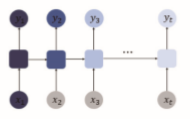

        − 위의 그림은 첫번째 입력값인 x1의 정보량을 짙은 남색으로 표현했을때, 색이 점차 옅어지는 것으로 시점이 지날수록 x1의 정보량이 손실되어가는 과정을 표현
        
        − 뒤로 갈수록 x1의 정보량은 손실되고, 시점이 충분히 긴 상황에서는 x1의 전체 정보에 대한 영향력은 거의 의미가 없을수도 있음

##### LSTM의구조
- 이러한 전통적인 RNN의 단점을 보완한 RNN의 일종을 장단기 메모리(Long Short-Term Memory)라고 하며, 줄여서 LSTM이라고 함
- LSTM은 은닉층의 메모리셀에입력게이트, 망각게이트, 출력게이트를 추가하여 불필요 한기억을 지우고, 기억해야할 것들을 정함
    - 즉,LSTM은은닉상태(hidden state)를 계산하는식이전통적인RNN보다조금더 복잡해졌으며셀상태(cell state)라는값을 추가함
- 오른쪽그림에서는t시점의 셀상태를Ct로 표현하고 있음
- LSTM은RNN과비교하여 긴 시퀀스의입력을 처리하는데 탁월한 성능을 보임
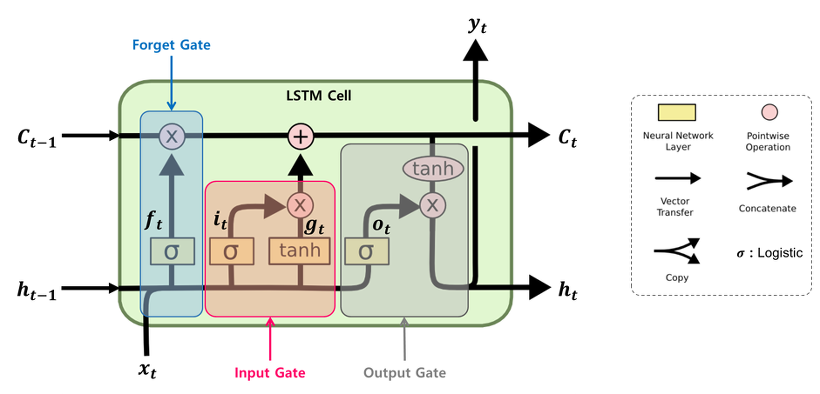

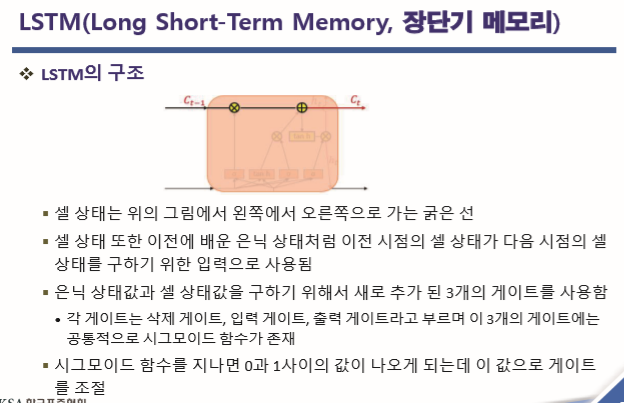

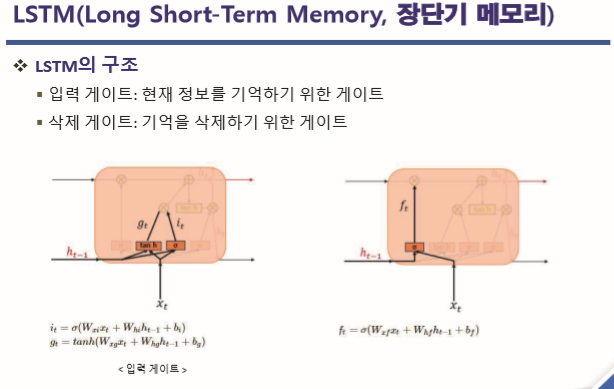

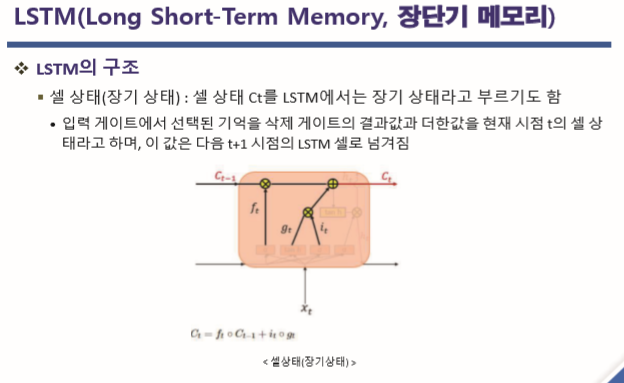

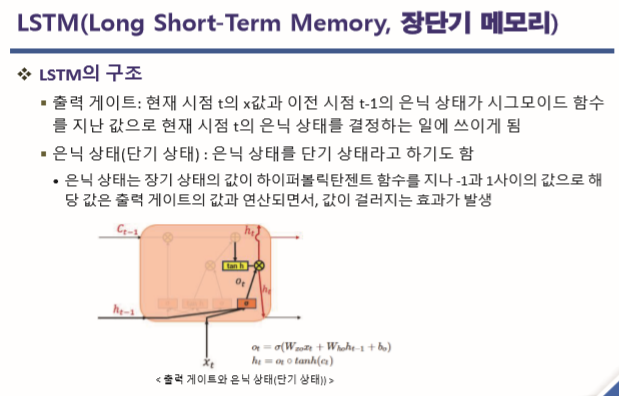

In [43]:
import pandas as pd
df = pd.read_csv('ArticlesApril2018.csv')
df.head()

articleID  articleWordCount  \
0  5adf6684068401528a2aa69b               781   
1  5adf653f068401528a2aa697               656   
2  5adf4626068401528a2aa628              2427   
3  5adf40d2068401528a2aa619               626   
4  5adf3d64068401528a2aa60f               815   

                                      byline documentType  \
0                             By JOHN BRANCH      article   
1                           By LISA FRIEDMAN      article   
2                              By PETE WELLS      article   
3  By JULIE HIRSCHFELD DAVIS and PETER BAKER      article   
4             By IAN AUSTEN and DAN BILEFSKY      article   

                                            headline  \
0  Former N.F.L. Cheerleaders’ Settlement Offer: ...   
1  E.P.A. to Unveil a New Rule. Its Effect: Less ...   
2                            The New Noma, Explained   
3                                            Unknown   
4                                            Unknown   

                                            keywords  multimedia     newDesk  \
0  ['Workplace Hazards and Violations', 'Football...          68      Sports   
1  ['Environmental Protection Agency', 'Pruitt, S...          68     Climate   
2  ['Restaurants', 'Noma (Copenhagen, Restaurant)...          66      Dining   
3  ['Macron, Emmanuel (1977- )', 'Trump, Donald J...          68  Washington   
4  ['Toronto, Ontario, Attack (April, 2018)', 'Mu...          68     Foreign   

   printPage              pubDate   sectionName  \
0          0  2018-04-24 17:16:49  Pro Football   
1          0  2018-04-24 17:11:21       Unknown   
2          0  2018-04-24 14:58:44       Unknown   
3          0  2018-04-24 14:35:57        Europe   
4          0  2018-04-24 14:21:21        Canada   

                                             snippet              source  \
0  “I understand that they could meet with us, pa...  The New York Times   
1  The agency plans to publish a new regulation T...  The New York Times   
2  What’s it like to eat at the second incarnatio...  The New York Times   
3  President Trump welcomed President Emmanuel Ma...  The New York Times   
4  Alek Minassian, 25, a resident of Toronto’s Ri...  The New York Times   

  typeOfMaterial                                             webURL  
0           News  https://www.nytimes.com/2018/04/24/sports/foot...  
1           News  https://www.nytimes.com/2018/04/24/climate/epa...  
2           News  https://www.nytimes.com/2018/04/24/dining/noma...  
3           News  https://www.nytimes.com/2018/04/24/world/europ...  
4           News  https://www.nytimes.com/2018/04/24/world/canad...

In [44]:
print(df.columns)
print('열의 개수: ', len(df.columns))

Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')
열의 개수:  15


In [45]:
df['headline'].isnull().values.any()

False

In [47]:
headline = []
headline.extend(list(df.headline.values))
headline[:5]
# 이는 headline 전체에 걸쳐 충간, 중간에 unknown이라는 데이터가 있기 때문
# 비록 Null값은 아니지만 실습에 도움이 되지 않는 노이즈 데이터에 해당되므로 제거해줄 필요가 있음

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

In [48]:
len(headline)

1324

In [49]:
headline = [n for n in headline if n != "Unknown"]
len(headline)

1214

In [50]:
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [52]:
# 구두점 제거와 단어의 소문자화
from string import punctuation
def repreprocessing(s):
    s = s.encode("UTF8").decode("ascii", "ignore")
    # 구두점 제거와 동시에 소문자화
    return ''.join(c for c in s if c not in punctuation).lower()

text = [repreprocessing(x) for x in headline]
text[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

In [54]:
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기: %d' % vocab_size)

단어 집합의 크기: 3494


In [55]:
sequences = list()

for line in text: # 1214개의 데이터에 대해서 1개씩 가져온다.
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)
        
sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [56]:
# 어떤 정수가 어떤 단어를 의미하는지 보기위한 과정
index_to_word = {}
for key, value in t.word_index.items():
    index_to_word[value] = key
    
index_to_word[582]

'offer'

In [57]:
# 패딩작업을 수행하기 위해 가장 긴 데이터의 길이 확인
max_len = max(len(i) for i in sequences)
print(max_len)

24


In [58]:
from keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre')
# padding = 'pre'는 0을 앞에서부터 채움
print(sequences[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


Using TensorFlow backend.


In [59]:
import numpy as np
sequences = np.array(sequences)
X = sequences[:, :-1]
y = sequences[:, -1]

In [60]:
print(X[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]


In [63]:
print(y[:3])

[ 269  371 1115]


In [64]:
# y 데이터를 one-hot encoding
from keras.utils import to_categorical
y = to_categorical(y, num_classes = vocab_size)

In [66]:
# 모델 설계
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = max_len-1))
# y데이터를 분리하였으므로 이제 X데이터의 길이는 기존 데이터의 길이 -1
model.add(LSTM(128))
model.add(Dense(vocab_size, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X, y, epochs = 200, verbose=2)

Epoch 1/200
 - 7s - loss: 7.6449 - acc: 0.0301
Epoch 2/200
 - 6s - loss: 7.1159 - acc: 0.0295
Epoch 3/200
 - 6s - loss: 6.9713 - acc: 0.0365
Epoch 4/200
 - 6s - loss: 6.8301 - acc: 0.0442
Epoch 5/200
 - 7s - loss: 6.6715 - acc: 0.0461
Epoch 6/200
 - 7s - loss: 6.4975 - acc: 0.0504
Epoch 7/200
 - 7s - loss: 6.3000 - acc: 0.0543
Epoch 8/200
 - 7s - loss: 6.0977 - acc: 0.0574
Epoch 9/200
 - 7s - loss: 5.9026 - acc: 0.0642
Epoch 10/200
 - 7s - loss: 5.7143 - acc: 0.0673
Epoch 11/200
 - 8s - loss: 5.5355 - acc: 0.0763
Epoch 12/200
 - 7s - loss: 5.3653 - acc: 0.0795
Epoch 13/200
 - 7s - loss: 5.2020 - acc: 0.0851
Epoch 14/200
 - 7s - loss: 5.0451 - acc: 0.0939
Epoch 15/200
 - 7s - loss: 4.8989 - acc: 0.1007
Epoch 16/200
 - 7s - loss: 4.7572 - acc: 0.1147
Epoch 17/200
 - 7s - loss: 4.6176 - acc: 0.1278
Epoch 18/200
 - 7s - loss: 4.4852 - acc: 0.1387
Epoch 19/200
 - 7s - loss: 4.3575 - acc: 0.1584
Epoch 20/200
 - 7s - loss: 4.2320 - acc: 0.1776
Epoch 21/200
 - 7s - loss: 4.1104 - acc: 0.1935
E

Epoch 171/200
 - 8s - loss: 0.2954 - acc: 0.9163
Epoch 172/200
 - 8s - loss: 0.2979 - acc: 0.9155
Epoch 173/200
 - 8s - loss: 0.2958 - acc: 0.9171
Epoch 174/200
 - 8s - loss: 0.2929 - acc: 0.9166
Epoch 175/200
 - 11s - loss: 0.2947 - acc: 0.9149
Epoch 176/200
 - 9s - loss: 0.2913 - acc: 0.9155
Epoch 177/200
 - 8s - loss: 0.2876 - acc: 0.9171
Epoch 178/200
 - 9s - loss: 0.2858 - acc: 0.9170
Epoch 179/200
 - 9s - loss: 0.2848 - acc: 0.9171
Epoch 180/200
 - 8s - loss: 0.2892 - acc: 0.9159
Epoch 181/200
 - 8s - loss: 0.2859 - acc: 0.9161
Epoch 182/200
 - 8s - loss: 0.2886 - acc: 0.9159
Epoch 183/200
 - 8s - loss: 0.2883 - acc: 0.9164
Epoch 184/200
 - 8s - loss: 0.2897 - acc: 0.9154
Epoch 185/200
 - 8s - loss: 0.2983 - acc: 0.9140
Epoch 186/200
 - 8s - loss: 0.3158 - acc: 0.9112
Epoch 187/200
 - 8s - loss: 0.2968 - acc: 0.9132
Epoch 188/200
 - 8s - loss: 0.2806 - acc: 0.9152
Epoch 189/200
 - 8s - loss: 0.2760 - acc: 0.9162
Epoch 190/200
 - 8s - loss: 0.2755 - acc: 0.9168
Epoch 191/200
 - 8s

In [67]:
def sentence_generation(model, t, current_word, n):
    init_word = current_word
    sentence = ''
    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=23, padding = 'pre')
        result = model.predict_classes(encoded, verbose = 0)
        for word, index in t.word_index.items():
            if index == result:
                break
        current_word = current_word + ' ' + word
        sentence = sentence + ' ' + word
        
    sentence = init_word + sentence
    return sentence

In [68]:
print(sentence_generation(model, t, 'i', 10))

i disapprove of school vouchers can i still apply for them


In [69]:
print(sentence_generation(model, t, 'how', 10))

how to serve a deranged tyrant stoically need greenpeace the broken


# 중요!!!!!!!!!!!!!!!!!!!!!!
- Module8

    -Part 05. Session-based 딥러닝
    
        03. 응용사례실습

In [1]:
import csv

f = open("tiny-shakespeare.txt",'r',encoding = 'utf-8')
rdr = csv.reader(f, delimiter = '\t')
rdw = list(rdr)

print(rdw[:9])

f.close()

[['First Citizen:'], ['Before we proceed any further, hear me speak.'], [], ['All:'], ['Speak, speak.'], [], ['First Citizen:'], ['You are all resolved rather to die than to famish?'], []]


In [ ]:
f = open("tiny-shakespeare.txt", 'r')
data = f.read()
print(data)
f.close()

data_split = data.split("\n")

text=[]
for part in data_split:
    if (re.findall(':$', part)!=[':'])&(part!=''):
        text.append(part)

In [2]:
tiny = []

for i in rdw:
    if i:
        if i[0][-1] != ':':
            tiny.append(i[0])

In [3]:
tiny

['Before we proceed any further, hear me speak.',
 'Speak, speak.',
 'You are all resolved rather to die than to famish?',
 'Resolved. resolved.',
 'First, you know Caius Marcius is chief enemy to the people.',
 "We know't, we know't.",
 "Let us kill him, and we'll have corn at our own price.",
 "Is't a verdict?",
 "No more talking on't; let it be done: away, away!",
 'One word, good citizens.',
 'We are accounted poor citizens, the patricians good.',
 'What authority surfeits on would relieve us: if they',
 'would yield us but the superfluity, while it were',
 'wholesome, we might guess they relieved us humanely;',
 'but they think we are too dear: the leanness that',
 'afflicts us, the object of our misery, is as an',
 'inventory to particularise their abundance; our',
 'sufferance is a gain to them Let us revenge this with',
 'our pikes, ere we become rakes: for the gods know I',
 'speak this in hunger for bread, not in thirst for revenge.',
 'Would you proceed especially against Ca

In [4]:
# 구두점 제거와 단어의 소문자화
from string import punctuation
def repreprocessing(s):
    s = s.encode("UTF8").decode("ascii", "ignore")
    # 구두점 제거와 동시에 소문자화
    return ''.join(c for c in s if c not in punctuation).lower()

text = [repreprocessing(x) for x in tiny]
text[:5]

['before we proceed any further hear me speak',
 'speak speak',
 'you are all resolved rather to die than to famish',
 'resolved resolved',
 'first you know caius marcius is chief enemy to the people']

In [5]:
# 단어 vocabulary 만들기
from keras_preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기: %d' % vocab_size)

단어 집합의 크기: 12506


In [6]:
sequences = list()

for line in text:
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)
        
sequences[:11]

[[130, 33],
 [130, 33, 915],
 [130, 33, 915, 125],
 [130, 33, 915, 125, 575],
 [130, 33, 915, 125, 575, 111],
 [130, 33, 915, 125, 575, 111, 16],
 [130, 33, 915, 125, 575, 111, 16, 101],
 [101, 101],
 [6, 39],
 [6, 39, 35],
 [6, 39, 35, 1184]]

In [7]:
# 어떤 정수가 어떤 단어인지 그냥 확인요
index_to_word = {}
for key, value in t.word_index.items():
    index_to_word[value] = key
index_to_word[575]

'further'

In [8]:
# 패딩 작업
max_len = max(len(i) for i in sequences)
print(max_len)

16


In [9]:
from keras.preprocessing.sequence import pad_sequences
sequences = pad_sequences(sequences, maxlen = max_len, padding = 'pre')
print(sequences[:3])

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 130  33]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 130  33 915]
 [  0   0   0   0   0   0   0   0   0   0   0   0 130  33 915 125]]


In [10]:
# x와 y로 나누기
import numpy as np
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:, -1]
print(X[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 130]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 130  33]
 [  0   0   0   0   0   0   0   0   0   0   0   0 130  33 915]]


In [13]:
print(y[:3])

[ 33 915 125]


In [14]:
# 원핫인코딩
from keras.utils import to_categorical
y = to_categorical(y, num_classes = vocab_size)

In [16]:
# 모델 설계
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length = max_len-1))
model.add(LSTM(128))
model.add(Dense(vocab_size, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X, y, epochs = 30, verbose=2)

Epoch 1/30
 - 182s - loss: 7.3452 - acc: 0.0286
Epoch 2/30
 - 181s - loss: 7.2478 - acc: 0.0281
Epoch 3/30
 - 181s - loss: 6.9346 - acc: 0.0360
Epoch 4/30
 - 178s - loss: 6.4355 - acc: 0.0623
Epoch 5/30
 - 178s - loss: 6.0892 - acc: 0.0831
Epoch 6/30
 - 178s - loss: 5.8334 - acc: 0.0912
Epoch 7/30
 - 178s - loss: 5.6022 - acc: 0.0980
Epoch 8/30
 - 180s - loss: 5.3965 - acc: 0.1049
Epoch 9/30
 - 178s - loss: 5.2125 - acc: 0.1106
Epoch 10/30
 - 176s - loss: 5.0533 - acc: 0.1194
Epoch 11/30
 - 177s - loss: 4.9099 - acc: 0.1293
Epoch 12/30
 - 177s - loss: 4.7797 - acc: 0.1405
Epoch 13/30
 - 179s - loss: 4.6612 - acc: 0.1511
Epoch 14/30
 - 179s - loss: 4.5516 - acc: 0.1628
Epoch 15/30
 - 178s - loss: 4.4505 - acc: 0.1736
Epoch 16/30
 - 176s - loss: 4.3560 - acc: 0.1854
Epoch 17/30
 - 176s - loss: 4.2707 - acc: 0.1960
Epoch 18/30
 - 178s - loss: 4.1908 - acc: 0.2064
Epoch 19/30
 - 179s - loss: 4.1174 - acc: 0.2164
Epoch 20/30
 - 176s - loss: 4.0492 - acc: 0.2258
Epoch 21/30
 - 178s - loss: 3

In [25]:
t = Tokenizer()
def sentence_generation(model, t, current_word, n):
    init_word = current_word
    sentence = ''
    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0]
        encoded = pad_sequences([encoded], maxlen=15, padding = 'pre')
        result = model.predict_classes(encoded, verbose = 0)
        for word, index in t.word_index.items():
            if index == result:
                break
        current_word = current_word + ' ' + word
        sentence = sentence + ' ' + word
        
    sentence = init_word + sentence
    return sentence

In [32]:
print(sentence_generation(model, t, 'king', 10))

UnboundLocalError: local variable 'word' referenced before assignment

# 엔드게임 크롤링

In [34]:
import requests
from bs4 import BeautifulSoup

test_url = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=136900&type=after&page=1"
resp = requests.get(test_url)
html = BeautifulSoup(resp.content, 'html.parser')
html


<!DOCTYPE html>

<html lang="ko">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<title>네이버 영화</title>
<link href="https://ssl.pstatic.net/static/m/movie/icons/naver_movie_favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/css/common.css?20190626140025" rel="stylesheet" type="text/css">
<link href="/css/movie_tablet.css?20190626140025" rel="stylesheet" type="text/css"/>
<link href="/css/movie_end.css?20190626140025" rel="stylesheet" type="text/css"/>
<script src="/js/deploy/movie.all.js?20190626140025" type="text/javascript"></script>
</link></head>
<body>
<!-- content -->
<input id="movieCode" name="movieCode" type="hidden" value="136900"/>
<input id="onlyActualPointYn" name="onlyActualPointYn" type="hidden" value="N"/>
<input id="order" name="order" type="hidden" value="sympathyScore"/>
<input id="page" name="page" type="hidden" value="1"/>
<input id="point" name="point" type="hidden" value="0"/>
<div class="ifr_area basic_ifr"

In [35]:
score_result = html.find('div', {'class': 'score_result'})
lis = score_result.findAll('li')
lis[0]

<li>
<div class="star_score">
<span class="st_off"><span class="st_on" style="width:100.0%"></span></span><em>10</em>
</div>
<div class="score_reple">
<p>마블 3000만큼 사랑합니다  </p>
<dl>
<dt>
<em>
<a href="#" onclick="javascript:showPointListByNid(15535812, 'after');parent.clickcr(this, 'ara.uid', '', '', event); return false;" target="_top">
<span>전은호(eunh****)</span>
</a>
</em>
<em>2019.04.24 10:31</em>
</dt>
<dd>
<a class="go_report2" href="#" onclick="parent.clickcr(this, 'ara.report', '', '', event); common.report('false','eunh****', 'cuWtIqx/FVBhoiD/uyawMqH95rImK+ZB1QQ9TAdficY=', '마블 3000만큼 사랑합니다 ', '15535812', 'point_after', false);return false;"><em>신고</em></a>
</dd>
</dl>
</div>
<div class="btn_area">
<a class="_sympathyButton" href="#" onclick="parent.clickcr(this, 'ara.sym', '', '', event);"><span class="blind">공감</span></a><strong><span class="sympathy_15535812 count">22480</span></strong>
<a class="_notSympathyButton" href="#" onclick="parent.clickcr(this, 'ara.opp', '', '', eve

In [36]:
review_text = lis[0].find('p').getText()
review_text

'마블 3000만큼 사랑합니다  '

In [ ]:
review_list = []
def get_data(url):
    for i in range(1, int(total_count / 10) + 1):
        url = test_url + '&page=' + str(i)
        resp = requests.get(url)
        html = BeautifulSoup(resp.content, 'html.parser')
        score_result = html.find('div', {'class': 'score_result'})
        lis = score_result.findAll('li')
        for li in lis:        
            review_text = li.find('p').getText()
            review_list.append(review_text)
            print(li)
        # 간단하게 프린트만 했습니다.
    return review_list

In [ ]:
result = html.find('div', {'class':'score_total'}).find('strong').findChildren('em')[1].getText()
int(result.replace(',', ''))

In [ ]:
test_url = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=136900&type=after'
resp = requests.get(test_url)
html = BeautifulSoup(resp.content, 'html.parser')
result = html.find('div', {'class':'score_total'}).find('strong').findChildren('em')[1].getText()
total_count = int(result.replace(',', ''))


#     print('url: "' + url + '" is parsing....')
review = get_data(url)

['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄청 울었어요ㅠㅠ  ', '관람객두말 필요하냐 엔드게임인데  ', '관람객3번째다 말이 필요가 없다 최고다  ', '관람객울었음... 이제 지구는.누가 지키나? 가슴 한구석이 너무 허전함. 쵝오  ', '역사가 될 작품... 그 역사와 함께 했다는 것이 참 좋다.  앞으로 걱정이 좀 되지만 마블이기에 기대해본다  ', '관람객최고에여 또 보고시품 ㅠ  ', '어벤져스 중 레전드임 ㄹㅇ 안보면 간첩  ', '3시간? 30분인줄..  ', '관람객최고였습니다. 10년동안  ', '관람객어벤저스 팬됐다ㅠㅠㅠ  ', '결말을 미리 알고 봤어요 스포땜에ㅠㅠ근데도 정말 최고의 감동이었네요..3000만큼 사랑해...아임 아이언맨...암튼 엄

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

